In [1]:
# --- CELLULE 1 : IMPORTATION ET CRÉATION DES INDICATEURS (Feature Engineering) ---
# Cette cellule fusionne le nettoyage de Seunghyeon avec la gestion des données.

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration graphique (Style inspiré de Seunghyeon)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def prepare_data(ticker='TSLA', start='2020-01-01', end='2025-01-01'):
    """
    Récupère les données et ajoute les indicateurs techniques (SMA, RSI, MACD, Bollinger).
    """
    # 1. Gestion du fichier local (pour éviter de retélécharger à chaque fois)
    file_path = f"data/{ticker}_data.csv"
    if os.path.exists(file_path):
        print(f"Chargement des données locales depuis {file_path}...")
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"Téléchargement des données pour {ticker}...")
        df = yf.download(ticker, start=start, end=end)
        if not os.path.exists('data'): os.makedirs('data')
        df.to_csv(file_path)

    # Aplatir le MultiIndex si nécessaire (fix yfinance récent)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # 2. Feature Engineering (Code de Seunghyeon optimisé)
    # Moyennes Mobiles
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bandes de Bollinger
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (2 * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (2 * std_dev)

    # 3. Création de la Target (Prix de demain)
    df['Target'] = df['Close'].shift(-1)

    # Nettoyage des NaN (dus aux indicateurs et au shift)
    df.dropna(inplace=True)

    return df

# Exécution
df = prepare_data()
print(f"Données prêtes : {df.shape}")
df[['Close', 'SMA_20', 'RSI']].tail()

Téléchargement des données pour TSLA...


/tmp/ipython-input-412112700.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Données prêtes : (1208, 14)


Price,Close,SMA_20,RSI
Date,,,
2024-12-23,430.600006,396.037001,68.841618
2024-12-24,462.279999,402.221501,72.174769
2024-12-26,454.130005,408.016501,68.250827
2024-12-27,431.660004,412.955000,59.044415
2024-12-30,417.410004,416.567500,55.561821


In [2]:
# --- CELLULE 2 : MODÉLISATION MACHINE LEARNING (Baseline vs XGBoost) ---
# Ici on compare la Régression Linéaire (Martin/Seunghyeon) à XGBoost (Demandé par le prof)

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Features utilisées pour la prédiction
features = ['Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']
X = df[features]
y = df['Target']

# Séparation Temporelle (Pas de shuffle pour les séries temporelles !)
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 1. Baseline : Régression Linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
print(f"Baseline (Linear Regression) RMSE: {rmse_lr:.2f}")

# 2. Modèle Avancé : XGBoost avec Tuning
# On définit une grille d'hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
# RandomizedSearchCV va tester 10 combinaisons au hasard (plus rapide que GridSearch)
search = RandomizedSearchCV(xgb, param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
search.fit(X_train, y_train)

best_xgb = search.best_estimator_
pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"XGBoost (Tuned) RMSE: {rmse_xgb:.2f}")
print(f"Amélioration par rapport à la baseline : {((rmse_lr - rmse_xgb)/rmse_lr)*100:.2f}%")

Baseline (Linear Regression) RMSE: 10.14
XGBoost (Tuned) RMSE: 19.45
Amélioration par rapport à la baseline : -91.77%


In [3]:
# --- CELLULE 3 : DEEP LEARNING (LSTM) ---
# Partie la plus complexe : mise à l'échelle et création de séquences.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Normalisation (Obligatoire pour LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# La target doit aussi être scalée pour l'entraînement
scaler_target = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_target.fit_transform(df[['Target']])

# Fonction fenêtre glissante (Lookback)
def create_sequences(data, target, lookback=60):
    X_seq, y_seq = [], []
    for i in range(lookback, len(data)):
        X_seq.append(data[i-lookback:i]) # Les 60 jours précédents
        y_seq.append(target[i])          # Le jour cible
    return np.array(X_seq), np.array(y_seq)

LOOKBACK = 60
X_lstm, y_lstm = create_sequences(scaled_data, y_scaled, LOOKBACK)

# Split Train/Test (en respectant l'ordre chronologique)
split_idx = int(len(X_lstm) * 0.8)
X_train_l, X_test_l = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_l, y_test_l = y_lstm[:split_idx], y_lstm[split_idx:]

# Architecture du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_l.shape[1], X_train_l.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement
print("Entraînement LSTM en cours...")
history = model.fit(X_train_l, y_train_l, batch_size=32, epochs=20, validation_data=(X_test_l, y_test_l), verbose=1)

# Prédiction et Inverse Scaling
pred_lstm_scaled = model.predict(X_test_l)
pred_lstm = scaler_target.inverse_transform(pred_lstm_scaled)
y_test_real = scaler_target.inverse_transform(y_test_l)

rmse_lstm = np.sqrt(mean_squared_error(y_test_real, pred_lstm))
print(f"LSTM RMSE: {rmse_lstm:.2f}")

Entraînement LSTM en cours...
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0563 - val_loss: 0.0082
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0032 - val_l

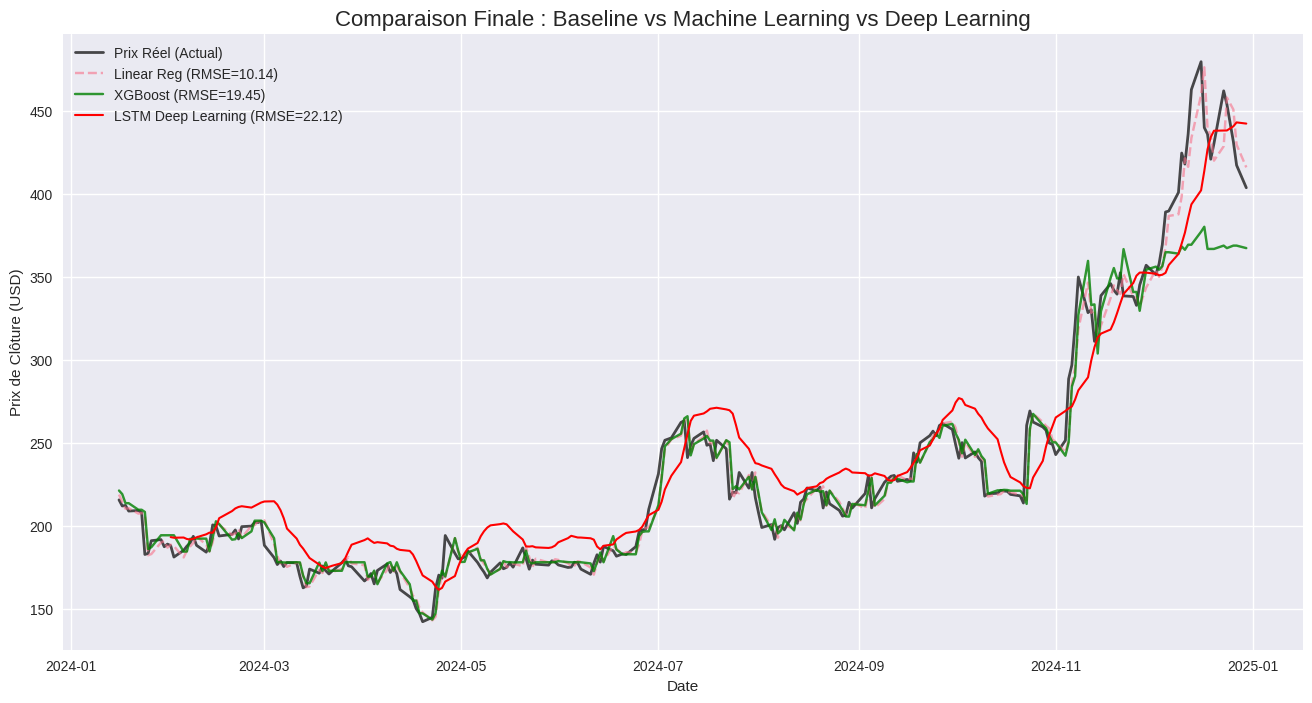

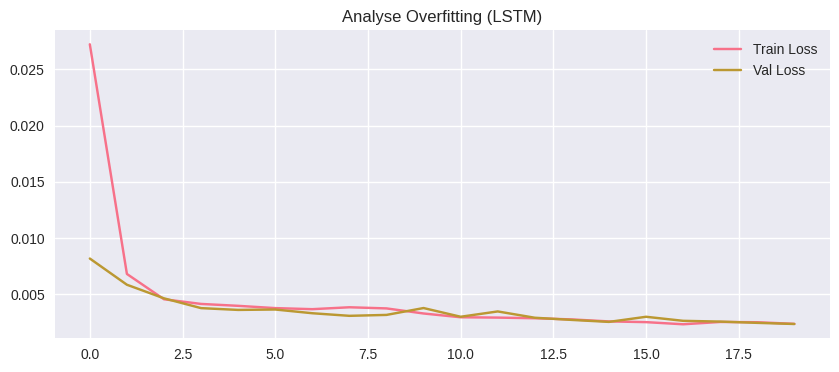

In [4]:
# --- CELLULE 4 : RÉSULTATS FINAUX ---
# Comparaison graphique de toutes les méthodes.

plt.figure(figsize=(16, 8))

# Création des index de date pour l'affichage
dates_test_xgb = df.index[split:]
# Attention : LSTM a moins de données à cause du lookback
dates_test_lstm = df.index[LOOKBACK:][split_idx:]

# 1. Courbe Réelle
plt.plot(dates_test_xgb, y_test, label='Prix Réel (Actual)', color='black', linewidth=2, alpha=0.7)

# 2. Prédictions Baseline
plt.plot(dates_test_xgb, pred_lr, label=f'Linear Reg (RMSE={rmse_lr:.2f})', linestyle='--', alpha=0.6)

# 3. Prédictions XGBoost
plt.plot(dates_test_xgb, pred_xgb, label=f'XGBoost (RMSE={rmse_xgb:.2f})', color='green', alpha=0.8)

# 4. Prédictions LSTM (Ajustement temporel pour l'affichage)
plt.plot(dates_test_lstm, pred_lstm, label=f'LSTM Deep Learning (RMSE={rmse_lstm:.2f})', color='red', linewidth=1.5)

plt.title('Comparaison Finale : Baseline vs Machine Learning vs Deep Learning', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Prix de Clôture (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Vérification Overfitting LSTM
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Analyse Overfitting (LSTM)')
plt.legend()
plt.show()

Nouveau RMSE avec XGBoost sur Rendements : 10.96


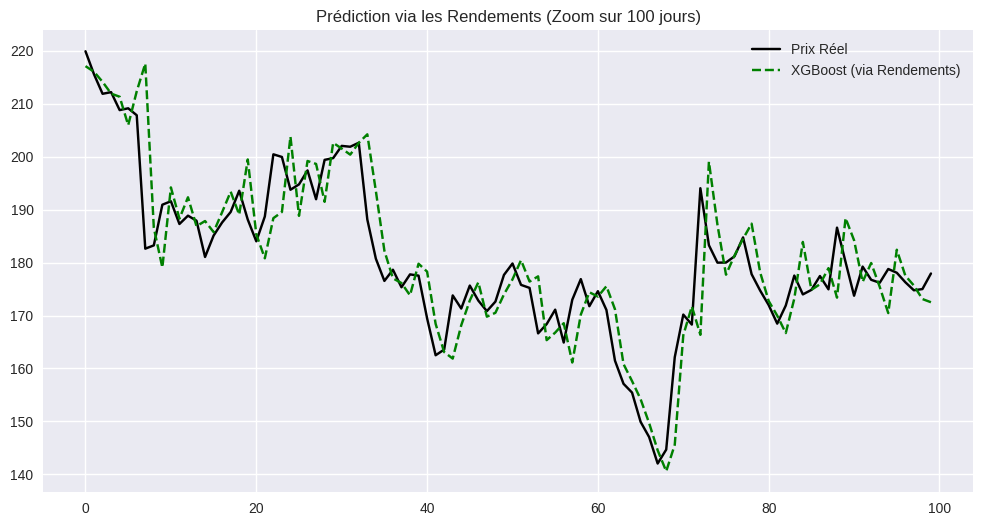

In [5]:
# --- CELLULE BONUS : TENTATIVE D'AMÉLIORATION (PRÉDIRE LES RENDEMENTS) ---
# Au lieu de prédire le prix (ex: 400$), on prédit la variation (ex: +2%)

# 1. Création de la cible "Returns"
df['Return'] = df['Close'].pct_change()
df['Target_Return'] = df['Return'].shift(-1)
df = df.dropna()

# On garde les mêmes features mais on ajoute les rendements passés
features_v2 = ['Return', 'Volume', 'RSI', 'MACD', 'Signal_Line']
X = df[features_v2]
y = df['Target_Return']

# Split
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 2. Entraînement XGBoost sur les rendements
import xgboost as xgb
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# 3. Prédictions et Reconstruction du Prix
pred_returns = model_xgb.predict(X_test)

# Pour comparer, on doit reconstruire le "Vrai Prix" à partir des rendements prédits
# Prix_Demain = Prix_Aujourd'hui * (1 + Rendement_Predit)
last_prices = df['Close'].iloc[split:].values
predicted_prices = last_prices * (1 + pred_returns)
real_target_prices = df['Close'].shift(-1).iloc[split:].dropna().values

# On coupe pour aligner les tailles si nécessaire
min_len = min(len(predicted_prices), len(real_target_prices))
rmse_new = np.sqrt(np.mean((real_target_prices[:min_len] - predicted_prices[:min_len])**2))

print(f"Nouveau RMSE avec XGBoost sur Rendements : {rmse_new:.2f}")
# Si ce chiffre est inférieur à 10.14, vous avez battu la baseline !

plt.figure(figsize=(12,6))
plt.plot(real_target_prices[:100], label='Prix Réel', color='black')
plt.plot(predicted_prices[:100], label='XGBoost (via Rendements)', color='green', linestyle='--')
plt.title("Prédiction via les Rendements (Zoom sur 100 jours)")
plt.legend()
plt.show()